In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


In [ ]:
train.head(10)

In [ ]:
structure.head(10)

In [ ]:
magnetic.shape

In [ ]:
magnetic.shape

In [ ]:
y = train['scalar_coupling_constant']

In [ ]:
train = pd.read_csv('train_0.csv', index_col=0)
test = pd.read_csv('test_0.csv', index_col=0)

In [ ]:
train_1 = pd.read_csv('train_1.csv', index_col=0)
test_1 = pd.read_csv('test_1.csv', index_col=0)

In [ ]:
train = pd.concat([train, train_1], axis=1)
test = pd.concat([test, test_1], axis=1)


In [ ]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

train['type'] = train_type.type
test['type'] = test_type.type

train['molecule_name'] = train_type.molecule_name
test['molecule_name'] = test_type.molecule_name


In [ ]:
train['atom_index_0'] = train_type.atom_index_0
test['atom_index_0'] = test_type.atom_index_0

train['atom_index_1'] = train_type.atom_index_1
test['atom_index_1'] = test_type.atom_index_1


In [ ]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [ ]:
scaler.columns

In [ ]:
np.unique(train['type'])

In [17]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [18]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x      ...        cos_f0  cos_f1  cos_center0  \
0  0.0019760   2.2   0.43      ...       -0.8164  1.0000      -1.0000   
1  0.0019760   2.2   0.43      ...       -1.0000  0.5005      -0.8164   
2  0.0019760   2.2   0.43      ...       -0.4998  0.5005      -0.8170   
3  0.0019760   2.2   0.43      ...       -0.5000  0.9995      -0.8164   
4  0.0002766   2.2   0.43      ...       -0.8170 -0.3335      -1.0010   

   cos_center1  atom_n     molecule_name        fc              sd  \
0  -0.00000083       4  dsgdb9nsd_000001  83.00000  0.254638671875   
1   0.81740000       4  dsgdb9nsd_000001 -11.03125  0.353027343750   
2   0.81700000       4  dsgdb9nsd_000001 -11.03125  0.353027343750   
3   0.81640000       4  dsgdb9nsd_000001 -11.03125  0.353027343750   
4  -0.00005250       4  dsgdb9nsd_000001  83.00000  0.254638671875   

            pso            dso  
0  1.2587890625  0.27197265625  
1  2.8574218750 -3.43359375000  
2  2.8593750000 -3.43359375000  
3  2.8593750000 -3.43359375000  
4  1.2587890625  0.27197265625  

[5 rows x 120 columns]

In [19]:
train.shape

(4658147, 120)

In [23]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 1,
          'seed': 666,
          'colsample_bytree': 1.0
         }

In [24]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor



In [25]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd',
       'pso', 'dso']]

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 6666 * 2
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=100)
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 1.1844	valid_1's l1: 1.3447
[1000]	training's l1: 0.957622	valid_1's l1: 1.22065
[1500]	training's l1: 0.818192	valid_1's l1: 1.16176
[2000]	training's l1: 0.714111	valid_1's l1: 1.12339
[2500]	training's l1: 0.633372	valid_1's l1: 1.09839
[3000]	training's l1: 0.566352	valid_1's l1: 1.07997
[3500]	training's l1: 0.510168	valid_1's l1: 1.06589
[4000]	training's l1: 0.461832	valid_1's l1: 1.05522
[4500]	training's l1: 0.419961	valid_1's l1: 1.04681
[5000]	training's l1: 0.383245	valid_1's l1: 1.0397
[5500]	training's l1: 0.350618	valid_1's l1: 1.03388
[6000]	training's l1: 0.321585	valid_1's l1: 1.02904
[6500]	training's l1: 0.295679	valid_1's l1: 1.02497
[7000]	training's l1: 0.272127	valid_1's l1: 1.02139
[7500]	training's l1: 0.250854	valid_1's l1: 1.01825
[8000]	training's l1: 0.231728	valid_1's l1: 1.01574
[8500]	training's l1: 0.214087	valid_1's l1: 1.01344
[9000]	training's l1: 0.198156	val

Early stopping, best iteration is:
[3623]	training's l1: 0.0115596	valid_1's l1: 0.482544
Fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.227343	valid_1's l1: 0.50669
[1000]	training's l1: 0.124734	valid_1's l1: 0.488095
[1500]	training's l1: 0.0722519	valid_1's l1: 0.482461
[2000]	training's l1: 0.0459064	valid_1's l1: 0.480446
[2500]	training's l1: 0.0304336	valid_1's l1: 0.479687
[3000]	training's l1: 0.0210024	valid_1's l1: 0.479248
[3500]	training's l1: 0.0149567	valid_1's l1: 0.479058
Early stopping, best iteration is:
[3631]	training's l1: 0.0137504	valid_1's l1: 0.478999
Fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.220799	valid_1's l1: 0.509867
[1000]	training's l1: 0.118099	valid_1's l1: 0.492087
[1500]	training's l1: 0.0697034	valid_1's l1: 0.48687
[2000]	training's l1: 0.0447421	valid_1's l1: 0.484722
[2500]	training's l1: 0.0291947	valid_1's l1: 0.48338
[3000]	training's l1: 0.02008

[10500]	training's l1: 0.11869	valid_1's l1: 0.446916
[11000]	training's l1: 0.112412	valid_1's l1: 0.445925
[11500]	training's l1: 0.106527	valid_1's l1: 0.445004
[12000]	training's l1: 0.101068	valid_1's l1: 0.444131
[12500]	training's l1: 0.095968	valid_1's l1: 0.443399
[13000]	training's l1: 0.0911906	valid_1's l1: 0.442749
Did not meet early stopping. Best iteration is:
[13332]	training's l1: 0.0881673	valid_1's l1: 0.442359
Fold 5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.585345	valid_1's l1: 0.642224
[1000]	training's l1: 0.485239	valid_1's l1: 0.577135
[1500]	training's l1: 0.423116	valid_1's l1: 0.542494
[2000]	training's l1: 0.378231	valid_1's l1: 0.520928
[2500]	training's l1: 0.343135	valid_1's l1: 0.506421
[3000]	training's l1: 0.31355	valid_1's l1: 0.494804
[3500]	training's l1: 0.288832	valid_1's l1: 0.486264
[4000]	training's l1: 0.267142	valid_1's l1: 0.479234
[4500]	training's l1: 0.248155	valid_1's l1: 0.473677
[5000]	train

[12500]	training's l1: 0.00796952	valid_1's l1: 0.241856
[13000]	training's l1: 0.00724313	valid_1's l1: 0.241807
Did not meet early stopping. Best iteration is:
[13332]	training's l1: 0.00680614	valid_1's l1: 0.241774
Fold 5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.231233	valid_1's l1: 0.301751
[1000]	training's l1: 0.172768	valid_1's l1: 0.276796
[1500]	training's l1: 0.138011	valid_1's l1: 0.26515
[2000]	training's l1: 0.113675	valid_1's l1: 0.258792
[2500]	training's l1: 0.0953253	valid_1's l1: 0.25471
[3000]	training's l1: 0.0808099	valid_1's l1: 0.251717
[3500]	training's l1: 0.0693454	valid_1's l1: 0.249742
[4000]	training's l1: 0.0597908	valid_1's l1: 0.248248
[4500]	training's l1: 0.0518951	valid_1's l1: 0.247068
[5000]	training's l1: 0.0452397	valid_1's l1: 0.246157
[5500]	training's l1: 0.0395637	valid_1's l1: 0.245391
[6000]	training's l1: 0.0347491	valid_1's l1: 0.244812
[6500]	training's l1: 0.0306008	valid_1's l1: 0.244346
[70

[7500]	training's l1: 0.00230986	valid_1's l1: 0.232349
[8000]	training's l1: 0.00200778	valid_1's l1: 0.232336
[8500]	training's l1: 0.00176855	valid_1's l1: 0.232323
[9000]	training's l1: 0.0015749	valid_1's l1: 0.232313
[9500]	training's l1: 0.00141878	valid_1's l1: 0.232304
[10000]	training's l1: 0.00129035	valid_1's l1: 0.2323
Early stopping, best iteration is:
[10372]	training's l1: 0.00121031	valid_1's l1: 0.232297
Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.562686	valid_1's l1: 0.599531
[1000]	training's l1: 0.474509	valid_1's l1: 0.53735
[1500]	training's l1: 0.420281	valid_1's l1: 0.504562
[2000]	training's l1: 0.380721	valid_1's l1: 0.483298
[2500]	training's l1: 0.349339	valid_1's l1: 0.468441
[3000]	training's l1: 0.323699	valid_1's l1: 0.45737
[3500]	training's l1: 0.301832	valid_1's l1: 0.448645
[4000]	training's l1: 0.282186	valid_1's l1: 0.44115
[4500]	training's l1: 0.264991	valid_1's l1: 0.435062
[5000]	training's l1: 

Did not meet early stopping. Best iteration is:
[13332]	training's l1: 0.112615	valid_1's l1: 0.397499
Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.255527	valid_1's l1: 0.299241
[1000]	training's l1: 0.200555	valid_1's l1: 0.269733
[1500]	training's l1: 0.167722	valid_1's l1: 0.256041
[2000]	training's l1: 0.144072	valid_1's l1: 0.247687
[2500]	training's l1: 0.125572	valid_1's l1: 0.2418
[3000]	training's l1: 0.110629	valid_1's l1: 0.237765
[3500]	training's l1: 0.0982969	valid_1's l1: 0.234832
[4000]	training's l1: 0.0878414	valid_1's l1: 0.232479
[4500]	training's l1: 0.0789151	valid_1's l1: 0.230614
[5000]	training's l1: 0.07118	valid_1's l1: 0.229147
[5500]	training's l1: 0.0644002	valid_1's l1: 0.227989
[6000]	training's l1: 0.0584341	valid_1's l1: 0.226944
[6500]	training's l1: 0.0531275	valid_1's l1: 0.226129
[7000]	training's l1: 0.0484096	valid_1's l1: 0.225436
[7500]	training's l1: 0.0442044	valid_1's l1: 0.22487
[8000]	trainin

[1000]	training's l1: 0.0706637	valid_1's l1: 0.165079
[1500]	training's l1: 0.0490455	valid_1's l1: 0.160394
[2000]	training's l1: 0.0355313	valid_1's l1: 0.157955
[2500]	training's l1: 0.0263806	valid_1's l1: 0.156594
[3000]	training's l1: 0.0200311	valid_1's l1: 0.1557
[3500]	training's l1: 0.015415	valid_1's l1: 0.155144
[4000]	training's l1: 0.0120306	valid_1's l1: 0.154811
[4500]	training's l1: 0.00955453	valid_1's l1: 0.154544
[5000]	training's l1: 0.00767833	valid_1's l1: 0.154385
[5500]	training's l1: 0.00626169	valid_1's l1: 0.154265
[6000]	training's l1: 0.00517977	valid_1's l1: 0.154166
[6500]	training's l1: 0.00434188	valid_1's l1: 0.154099
[7000]	training's l1: 0.0036871	valid_1's l1: 0.154042
[7500]	training's l1: 0.00317486	valid_1's l1: 0.153999
[8000]	training's l1: 0.00276335	valid_1's l1: 0.153971
[8500]	training's l1: 0.00243228	valid_1's l1: 0.153949
[9000]	training's l1: 0.00216295	valid_1's l1: 0.153931
[9500]	training's l1: 0.00193899	valid_1's l1: 0.153916
[10

In [26]:
predictions

array([ 17.71670102, 190.79788149,   9.4865519 , ...,   5.99607997,
         6.79633965, 123.44905038])

In [27]:
test.shape

(2505542, 116)

In [28]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [29]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [30]:
sub.shape

(2505542, 2)

In [31]:
len(predictions)

2505542

In [32]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.2.5.csv", index=False)

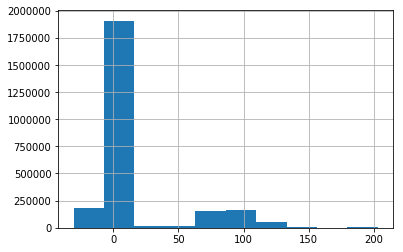

In [33]:
sub['scalar_coupling_constant'].hist()

In [34]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.2.5.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.2.5.csv', index=False)